## Packages and Scripts

In [46]:
# Objective functions
library("smoof")
library("ParamHelpers")

# Bayesian Optimization
library("mlrMBO")

# Data handling
library("data.table")

# Visualization
library("ggplot2")
library("ggpubr")

# IML 
library(iml)

# Further helpers
library("BBmisc")

theme_set(theme_pubr())

source("../R/marginal_effect.R")

# Section 3: Figures  

Section 3 describes the problem of a sampling bias in HPO. 

We show an illustration for the sampling bias when BO is used on a synthetic function

## Figure 1: Visualizing the Sampling Bias

We create mlrMBO runs with a GP surrogate model and the LCB infill criterion. We use different values of lambda, and compare it against a random search. 

In [39]:
dimension = 2
id = "StyblinskiTang"

obj = makeSingleObjectiveFunction(name = paste0(id, dimension, "D"), fn = function(x) {
        1 / 2 * sum(x^4 - 16 * x^2 + 5 * x)
    }, 
    par.set = makeParamSet(makeNumericVectorParam(id = "x", len = dimension, lower = - 5, upper = 5)), 
    global.opt.params = rep(-2.9035, dimension)
)

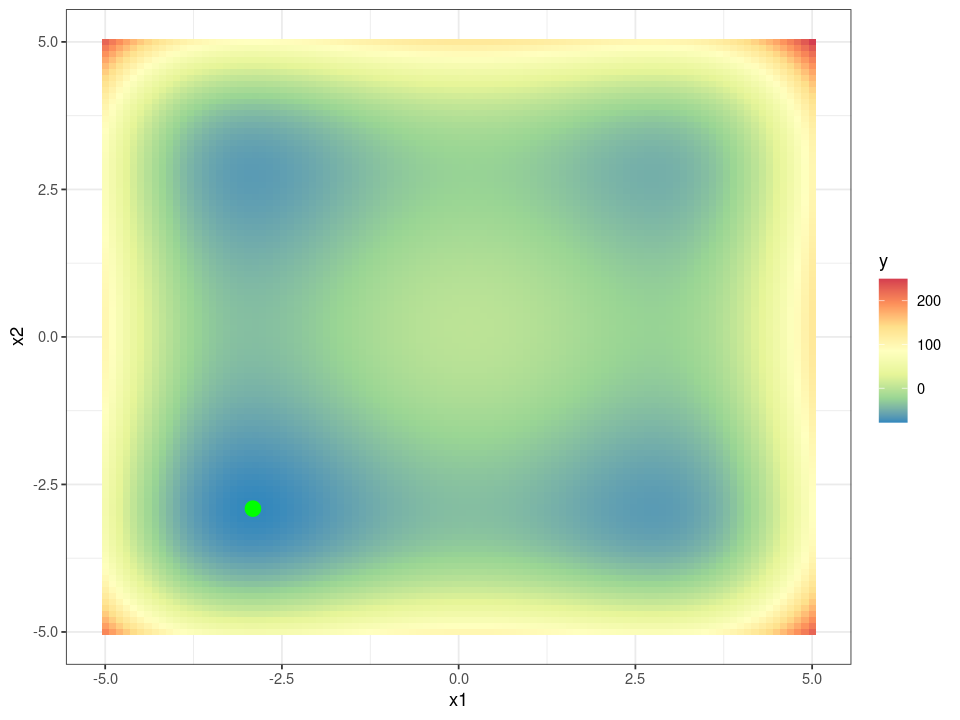

In [7]:
options(repr.plot.width=8, repr.plot.height=6)

ps = getParamSet(obj)

ps_ids = getParamIds(ps, repeated = TRUE, with.nr = TRUE)

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
x2 <- x1
y = outer(x1, x2, FUN = function(x1, x2) apply(cbind(x1, x2), 1, obj))

gg <- expand.grid(x1 = x1, x2 = x2)
gg$y = apply(gg, 1, obj)

p_obj = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = y))
p_obj = p_obj + scale_fill_distiller(palette = "Spectral")
p_obj = p_obj + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)

p_obj

In [88]:
# Create mlrMBO runs for different lambdas
max.evals = 50

runs = lapply(c(0.1, 2, 100), function(lambda) {
    
    ctrl = makeMBOControl()
    ctrl = setMBOControlTermination(ctrl, max.evals = max.evals)
    ctrl = setMBOControlInfill(ctrl, makeMBOInfillCritCB(cb.lambda = lambda))

    init_size = 4 * getParamLengths(ps)

    # If lambda is 100, we do a random search
    if (lambda == 100) {
        init_size = max.evals - 2
        max.evals = max.evals + 1
    }
        
    set.seed(1234)
    
    des = generateDesign(n = init_size, par.set = ps, fun = lhs::randomLHS)

    lrn = makeLearner("regr.km", predict.type = "se", covtype = "matern3_2", optim.method = "gen", nugget.stability = 10^(-8))

    res = mbo(obj, design = des, learner = lrn, control = ctrl, show.info = FALSE)
    
    return(res)
})


optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.030581e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  70.30581 9149.6 
  - best initial criterion value(s) :  -37.33105 


Thu Feb 11 07:28:11 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 7.030581e+01   <=  X3   <=    9.149600e+03 

NOTE: The total number of operators greater than population size
NOTE: I'm increasing the population size to 10 (operators+1).

Data Type: Floating Point
Operators (code number, name, population) 
	(1) Cloning........................... 	0
	(2) Uniform Mutation.................. 	1
	(3) Boundary Mutation................. 	1
	(4) Non-Uniform Mutation.............. 	1
	(5) Polytope Crossover................ 	1
	(6) Simple Cro

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -5.046097e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	3.897990e+00	G[ 1] :	-3.080305e-07
 X[ 2] :	3.421093e+00	G[ 2] :	-9.016822e-07
 X[ 3] :	1.424400e+03	G[ 3] :	1.297561e-09

Solution Found Generation 4
Number of Generations Run 5

Thu Feb 11 07:28:15 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 1.062615e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  106.2615 18169.52 
  - best initial criterion value(s) :  -74.31942 


Thu Feb 11 07:28:16 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 1.062615e+02   <=  X3   <=    1.816952e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -3.183714e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.000861e+00	G[ 1] :	5.298071e-06
 X[ 2] :	9.530268e+00	G[ 2] :	-2.336361e-06
 X[ 3] :	1.302295e+04	G[ 3] :	-6.559949e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:18 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 9.252203e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  92.52202 17694.2 
  - best initial criterion value(s) :  -33.76736 


Thu Feb 11 07:28:19 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 9.252202e+01   <=  X3   <=    1.769420e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 2.460253e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.896856e+00	G[ 1] :	2.932494e-05
 X[ 2] :	9.513078e+00	G[ 2] :	3.887518e-05
 X[ 3] :	1.145231e+04	G[ 3] :	-6.467967e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:25 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 7.125033e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  71.25033 14268.01 
  - best initial criterion value(s) :  19.78641 


Thu Feb 11 07:28:26 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 7.125033e+01   <=  X3   <=    1.426801e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 2.994678e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.226106e+00	G[ 1] :	2.133062e-04
 X[ 2] :	6.416415e+00	G[ 2] :	-1.406719e-04
 X[ 3] :	4.012317e+03	G[ 3] :	-1.059029e-04

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:26 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.985889e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  69.85888 13970.71 
  - best initial criterion value(s) :  6.070927 


Thu Feb 11 07:28:27 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.985888e+01   <=  X3   <=    1.397071e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 4.481279e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	5.685655e+00	G[ 1] :	-1.379253e-04
 X[ 2] :	5.847014e+00	G[ 2] :	2.120867e-04
 X[ 3] :	3.063784e+03	G[ 3] :	-7.265735e-05

Solution Found Generation 4
Number of Generations Run 5

Thu Feb 11 07:28:28 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.596928e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  65.96928 13207.94 
  - best initial criterion value(s) :  46.45824 


Thu Feb 11 07:28:29 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.596928e+01   <=  X3   <=    1.320794e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 5.430569e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.576998e+00	G[ 1] :	-3.633885e-07
 X[ 2] :	9.309685e+00	G[ 2] :	6.115299e-06
 X[ 3] :	1.014610e+04	G[ 3] :	-6.686878e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:30 2021
Total run time : 0 hours 0 minutes and 1 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.359306e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  63.59306 12718.31 
  - best initial criterion value(s) :  57.16111 


Thu Feb 11 07:28:31 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.359306e+01   <=  X3   <=    1.271831e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: 7.004684e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.093031e+00	G[ 1] :	1.467255e-04
 X[ 2] :	6.395391e+00	G[ 2] :	1.074464e-04
 X[ 3] :	3.704511e+03	G[ 3] :	-8.398445e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:33 2021
Total run time : 0 hours 0 minutes and 1 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 6.031693e-06 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  17.82472 15.58793 
  - variance bounds :  60.31693 12063.3 
  - best initial criterion value(s) :  67.12661 


Thu Feb 11 07:28:33 2021
Domains:
 1.000000e-10   <=  X1   <=    1.782472e+01 
 1.000000e-10   <=  X2   <=    1.558793e+01 
 6.031693e+01   <=  X3   <=    1.206330e+04 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.072231e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	4.357078e+00	G[ 1] :	-1.393824e-05
 X[ 2] :	3.957483e+00	G[ 2] :	-1.284390e-05
 X[ 3] :	9.180648e+03	G[ 3] :	-3.923636e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:39 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 3.106642e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  310.6642 39245.63 
  - best initial criterion value(s) :  -282.492 


Thu Feb 11 07:28:40 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 3.106642e+02   <=  X3   <=    3.924563e+04 

NOTE: The total number of oper

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.335881e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	5.900083e+00	G[ 1] :	5.662246e-06
 X[ 2] :	5.821073e+00	G[ 2] :	2.987848e-06
 X[ 3] :	1.368516e+04	G[ 3] :	9.468186e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:44 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 3.121054e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  312.1054 41698.1 
  - best initial criterion value(s) :  -156.8619 


Thu Feb 11 07:28:44 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 3.121054e+02   <=  X3   <=    4.169810e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.333713e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	6.346062e+00	G[ 1] :	-1.371567e-04
 X[ 2] :	6.381729e+00	G[ 2] :	-2.427776e-05
 X[ 3] :	1.630543e+04	G[ 3] :	7.450067e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:44 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 3.09753e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  309.753 41667.27 
  - best initial criterion value(s) :  -165.0475 


Thu Feb 11 07:28:45 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 3.097530e+02   <=  X3   <=    4.166727e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.305342e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.201923e+00	G[ 1] :	6.987637e-07
 X[ 2] :	9.409701e+00	G[ 2] :	6.131032e-07
 X[ 3] :	4.055850e+04	G[ 3] :	1.753850e-05

Solution Found Generation 4
Number of Generations Run 5

Thu Feb 11 07:28:46 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.981477e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  298.1477 40357.69 
  - best initial criterion value(s) :  -198.4938 


Thu Feb 11 07:28:47 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.981477e+02   <=  X3   <=    4.035769e+04 

NOTE: The total number of operat

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.290512e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.533204e+00	G[ 1] :	-4.874805e-06
 X[ 2] :	8.677045e+00	G[ 2] :	8.246482e-07
 X[ 3] :	3.158473e+04	G[ 3] :	2.989013e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:47 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.949221e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  294.9221 40087.91 
  - best initial criterion value(s) :  -246.9048 


Thu Feb 11 07:28:47 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.949221e+02   <=  X3   <=    4.008791e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.165042e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	8.186562e+00	G[ 1] :	4.685549e-06
 X[ 2] :	8.169272e+00	G[ 2] :	1.539612e-06
 X[ 3] :	2.356646e+04	G[ 3] :	6.302612e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:50 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.747407e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  274.7407 38095.35 
  - best initial criterion value(s) :  -177.187 


Thu Feb 11 07:28:50 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.747407e+02   <=  X3   <=    3.809535e+04 

NOTE: The total number of operato

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.135936e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.855264e+00	G[ 1] :	3.138280e-06
 X[ 2] :	7.883237e+00	G[ 2] :	-3.891772e-06
 X[ 3] :	2.073292e+04	G[ 3] :	8.125164e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:50 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.713863e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  271.3863 38182.09 
  - best initial criterion value(s) :  -173.7044 


Thu Feb 11 07:28:51 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.713863e+02   <=  X3   <=    3.818209e+04 

NOTE: The total number of opera

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -1.095309e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.599273e+00	G[ 1] :	4.943316e-05
 X[ 2] :	9.653619e+00	G[ 2] :	6.637873e-05
 X[ 3] :	3.601892e+04	G[ 3] :	2.954936e-05

Solution Found Generation 5
Number of Generations Run 5

Thu Feb 11 07:28:51 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.68059e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.94561 19.99952 
  - variance bounds :  268.059 38061.14 
  - best initial criterion value(s) :  -163.6926 


Thu Feb 11 07:28:52 2021
Domains:
 1.000000e-10   <=  X1   <=    1.994561e+01 
 1.000000e-10   <=  X2   <=    1.999952e+01 
 2.680590e+02   <=  X3   <=    3.806114e+04 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -9.447696e+01

Parameters at the Solution (parameter, gradient):

 X[ 1] :	9.897267e+00	G[ 1] :	9.847601e-06
 X[ 2] :	9.859779e+00	G[ 2] :	6.240025e-06
 X[ 3] :	3.707593e+04	G[ 3] :	2.913601e-05

Solution Found Generation 4
Number of Generations Run 5

Thu Feb 11 07:28:54 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.101344e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.60172 19.63837 
  - variance bounds :  210.1344 26346.4 
  - best initial criterion value(s) :  -718.192 


Thu Feb 11 07:28:55 2021
Domains:
 1.000000e-10   <=  X1   <=    1.960172e+01 
 1.000000e-10   <=  X2   <=    1.963837e+01 
 2.101344e+02   <=  X3   <=    2.634640e+04 

NOTE: The total number of operator

Warning message in (function (fn, nvars, max = FALSE, pop.size = 1000, max.generations = 100, :
“Stopped because hard maximum generation limit was hit.”



NOTE: HARD MAXIMUM GENERATION LIMIT HIT

Solution Fitness Value: -2.078637e+02

Parameters at the Solution (parameter, gradient):

 X[ 1] :	7.271686e+00	G[ 1] :	2.350962e-08
 X[ 2] :	8.074995e+00	G[ 2] :	7.622825e-08
 X[ 3] :	2.634640e+04	G[ 3] :	2.318609e-04

Solution Found Generation 4
Number of Generations Run 5

Thu Feb 11 07:28:55 2021
Total run time : 0 hours 0 minutes and 0 seconds

optimisation start
------------------
* estimation method   : MLE 
* optimisation method : gen 
* analytical gradient : used
* trend model : ~1
* covariance model : 
  - type :  matern3_2 
  - nugget : 2.943332e-05 
  - parameters lower bounds :  1e-10 1e-10 
  - parameters upper bounds :  19.71746 19.81429 
  - variance bounds :  294.3332 39264.93 
  - best initial criterion value(s) :  -340.104 


Thu Feb 11 07:28:55 2021
Domains:
 1.000000e-10   <=  X1   <=    1.971746e+01 
 1.000000e-10   <=  X2   <=    1.981429e+01 
 2.943332e+02   <=  X3   <=    3.926493e+04 

NOTE: The total number of operato

In [67]:
names(runs) = paste0("MBO_", c(0.1, 2, 100))

In [68]:
opdf = lapply(names(runs), function(name) {
    cbind(as.data.frame(runs[[name]]$opt.path), type = name)
})
opdf = do.call(rbind, opdf)
opdf$type = as.factor(opdf$type)
opdf = setDT(opdf)

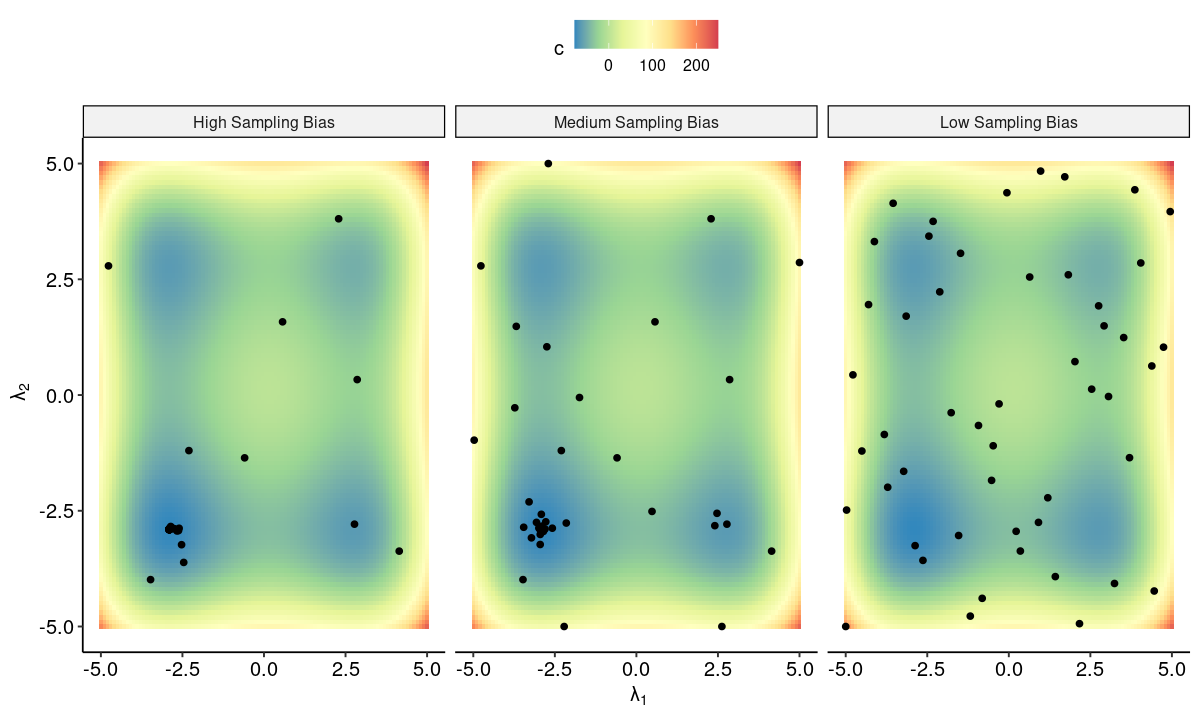

In [69]:
options(repr.plot.width=10, repr.plot.height=6)

opdf_sub = opdf[type %in% c("MBO_0.1", "MBO_2", "MBO_100")]
opdf_sub[type == "MBO_0.1"]$type = "High Sampling Bias"
opdf_sub[type == "MBO_2"]$type = "Medium Sampling Bias"
opdf_sub[type == "MBO_100"]$type = "Low Sampling Bias"

opdf_sub$c = opdf_sub$y
gg$c = gg$y

p1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = c))
p1 = p1 + scale_fill_distiller(palette = "Spectral")
# p = p + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)
p1 = p1 + geom_point(data = opdf_sub, aes(x = x1, y = x2)) + xlab(~ paste("\u03BB"[1])) + ylab(~ paste("\u03BB"[2]))
p1 = p1 + facet_wrap(. ~ type) 

p1

In [70]:
ggsave("sampling_bias.png", p1, width = 7, height = 4)

## Figure 2: Visualizing PDPs under the Sampling Bias

For the case for lambda = 0.1, we visualize two ICE curves to illustrate the effect of the sampling bias on the PDP estimate.

In [71]:
model = runs[["MBO_0.1"]]$models
model = model[[length(model)]]
df = opdf[type == "MBO_0.1"]
df$c = df$y

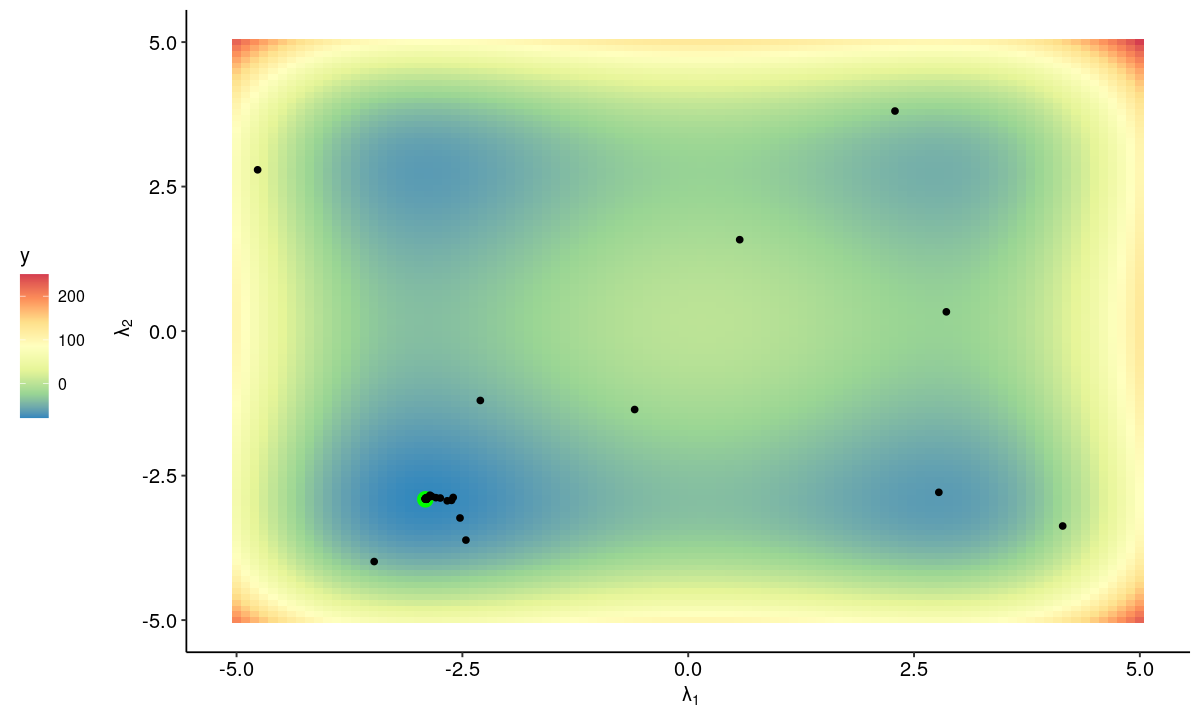

In [72]:
p = p_obj + geom_point(data = df, aes(x = x1, y = x2)) + xlab(~ paste("\u03BB"[1])) + ylab(~ paste("\u03BB"[2]))
p = p + theme(legend.position = "left")
p

In [73]:
# Plot a PDP with two ICE curves 
gridvalues = seq(-5, 5, length.out = 20)

id1 = 2
id2 = 17

ic1 = data.frame(x1 = gridvalues, x2 = df[id1, ]$x2)
ic1$y = apply(ic1, 1, obj)

ic2 = data.frame(x1 = gridvalues, x2 = df[id2, ]$x2)
ic2$y = apply(ic2, 1, obj)
ic2$type = "2"
ic1$type = "1"

In [74]:
ic = rbind(ic1, ic2)
ic = cbind(ic, predict(model, newdata = ic[, c("x1", "x2")])$data)

In [75]:
p1 = p + geom_hline(data = ic, aes(yintercept = x2, colour = type), show.legend = FALSE)

In [76]:
p2 = ggplot() + geom_line(data = ic, aes(x = x1, y = response, colour = type))
p2 = p2 + geom_ribbon(data = ic, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), alpha = 0.2)
p2 = p2 + geom_line(data = ic, aes(x = x1, y = y)) + xlab(~ paste("\u03BB"[1]))  + ylab("c")
p2 = p2 + facet_grid(type ~ .) + theme(legend.position = "none")

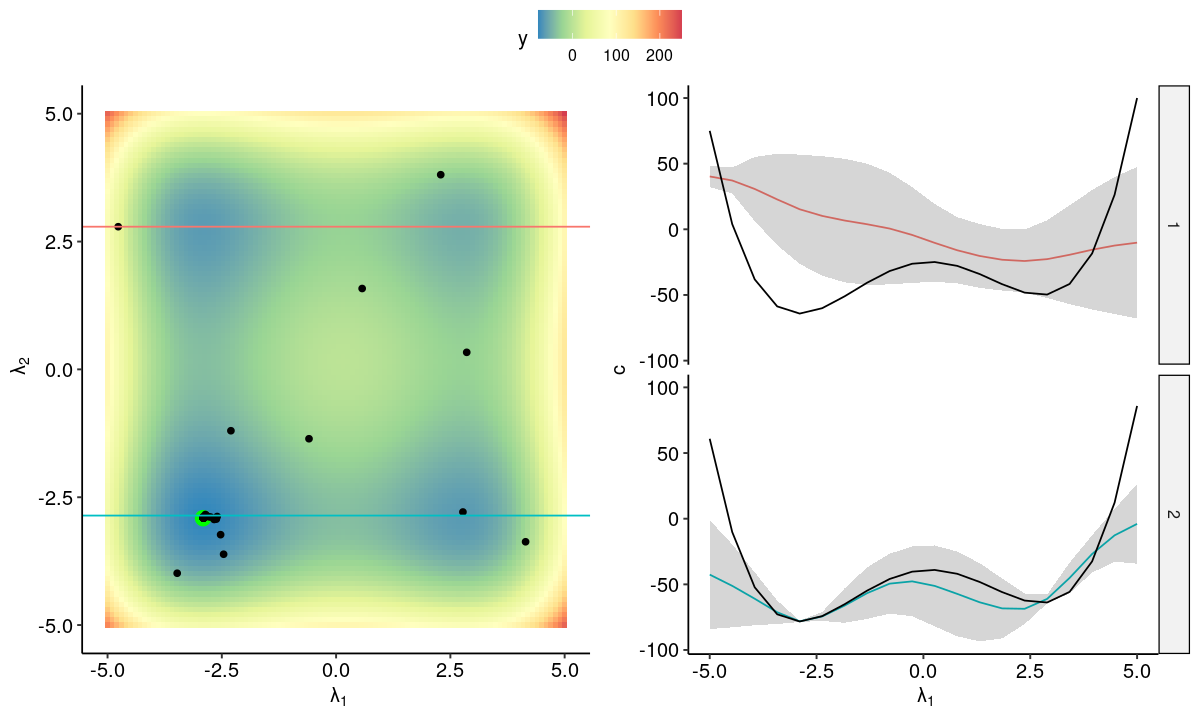

In [77]:
ggarrange(p1, p2, nrow = 1, common.legend = TRUE)

In [78]:
ggsave("ice_curves_example.png", ggarrange(p1, p2, nrow = 1, common.legend = TRUE), width = 7, height = 3.5)

# Section 4: Figures  

Section 4 introduces the uncertainty estimates. 

## Figure 2: Visualizing PDPs under the Sampling Bias

Figure 4 visualizes the uncertainty estimates for different degrees of the sampling bias. 

In [79]:
# Data to compute the Monte Carlo estimate
data = generateRandomDesign(1000, getParamSet(obj))

In [80]:
# Compute the ground-truth PDP

marginal_gt = marginal_effect(obj = obj, feature = "x1", data = data, model = model, grid.size = 20, all.features = model$features, method = "pdp")

p = ggplot(data = setDT(marginal_gt)[.type == "pdp", ], aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c"))

In [81]:
# Compute the PDPs for the different runs 

feature = "x1"

marginal_pd = lapply(names(runs), function(run) {
    mod = runs[[run]]$models[[1]]
    pp = marginal_effect_sd_over_mean(mod, feature, data, grid.size = 20, method = "pdp_var")
    pp$type = run
    pp
})

mins = opdf[, .SD[which.min(y)], by = type]

marginal_pd = do.call(rbind, marginal_pd)
marginal_pd$type = factor(marginal_pd$type)
marginal_pd = as.data.table(marginal_pd)

ERROR: Error in runs[[run]]$models[[1]]: subscript out of bounds


In [ ]:
marginal_pd[type == "MBO_0.1"]$type = "High Sampling Bias"
marginal_pd[type == "MBO_2"]$type = "Medium Sampling Bias"
marginal_pd[type == "MBO_100"]$type = "Low Sampling Bias"

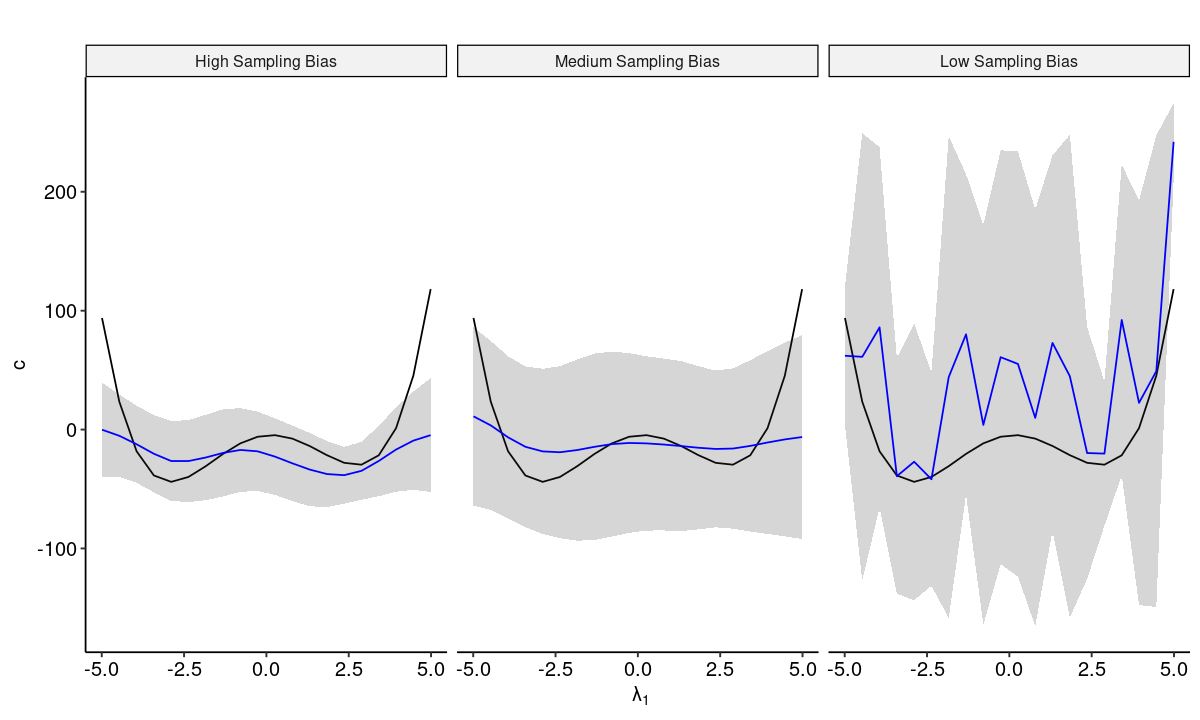

In [65]:
p = p + xlab(expression(lambda))
p1 = p + geom_ribbon(data = marginal_pd, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2) 
p1 = p1 + geom_line(data = marginal_pd, aes(x = x1, y = mean), colour = "blue")
p1 = p1 + xlab(~ paste("\u03BB"[1])) + facet_wrap(. ~ type ) + ggtitle("")
p1

In [ ]:
ggsave("pdp_comparison.png", p1, width = 6, height = 3)

### Preparation: Investigating the Fit

In [395]:
ps = getParamSet(obj)
gg = generateGridDesign(par.set = ps, resolution = 50L)
gg$y = apply(gg, 1, obj1)

In [396]:
ps

           Type len Def  Constr Req Tunable Trafo
x numericvector   2   - -5 to 5   -    TRUE     -

In [397]:
preds = lapply(names(models), function(idx) {
    pp = predict_on_grid(models[[idx]], gg)
    pp$type = idx
    pp
})
preds = do.call(rbind, preds)

preds$type = as.factor(preds$type)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



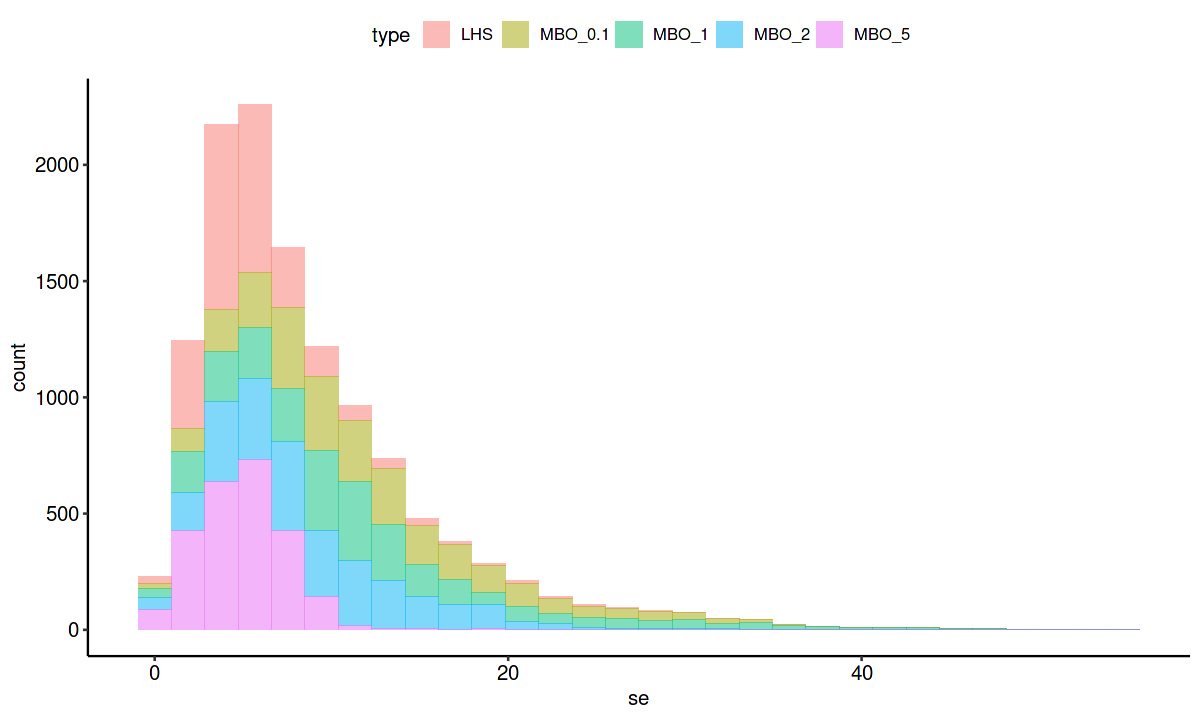

In [398]:
p = ggplot(data = preds, aes(x = se, fill = type)) + geom_histogram(alpha = 0.5)
p

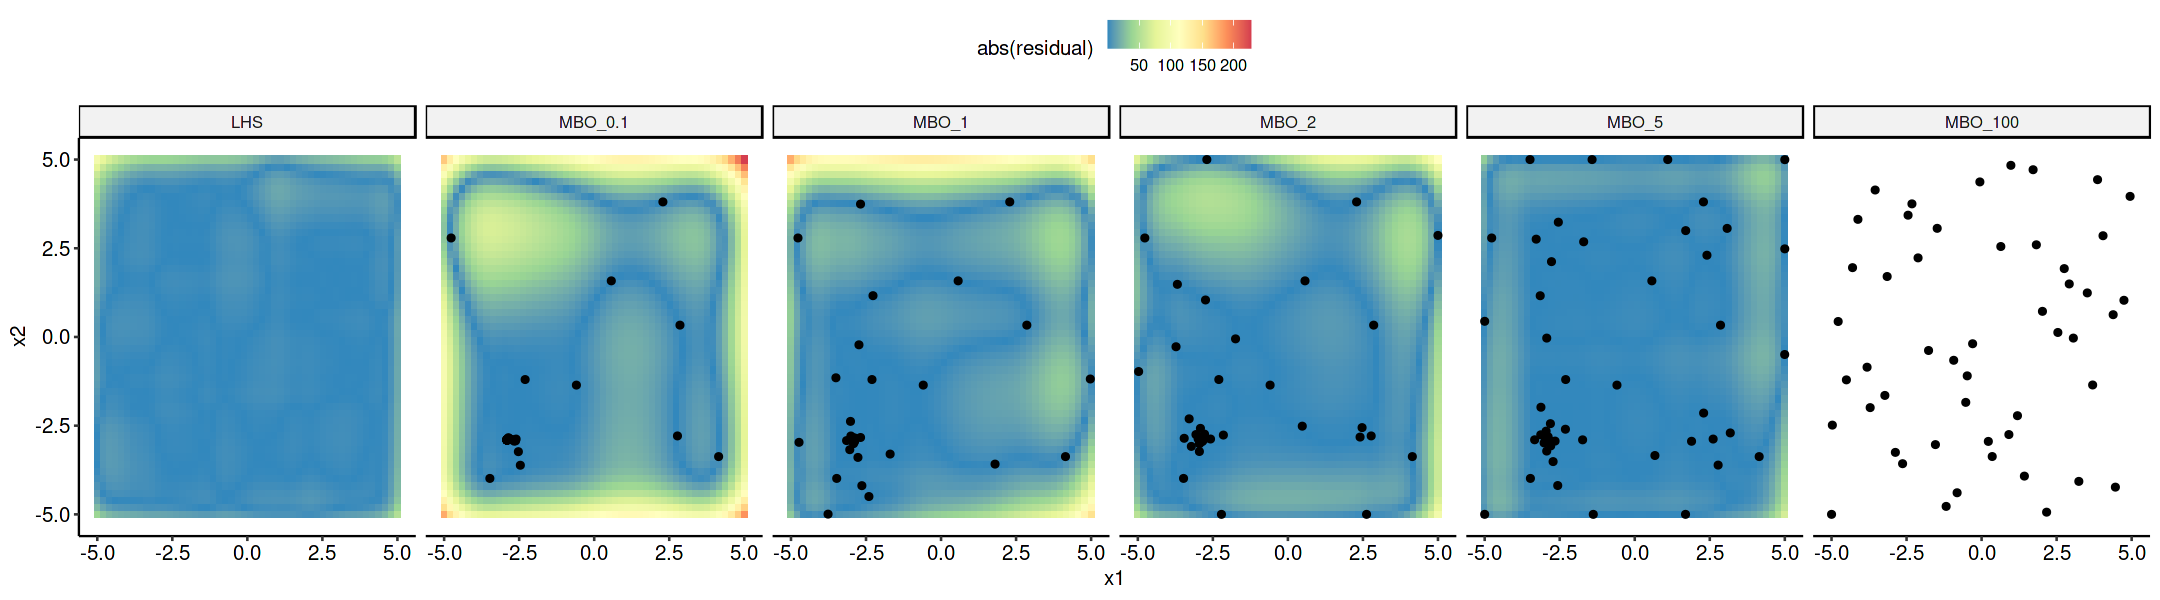

In [399]:
options(repr.plot.width=18, repr.plot.height=5)

p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

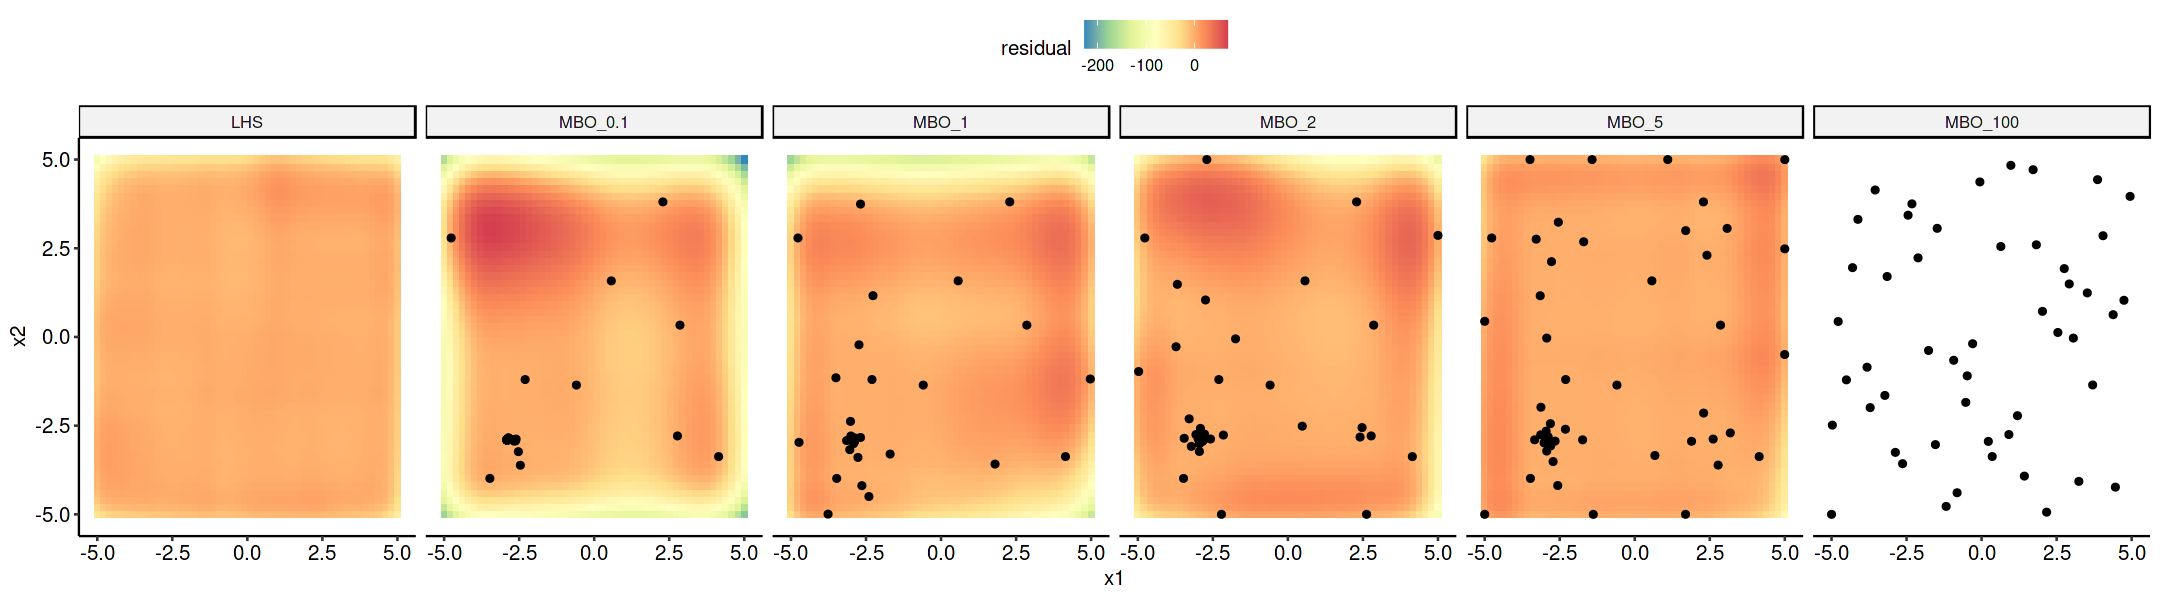

In [400]:
options(repr.plot.width=18, repr.plot.height=5)

p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = residual))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

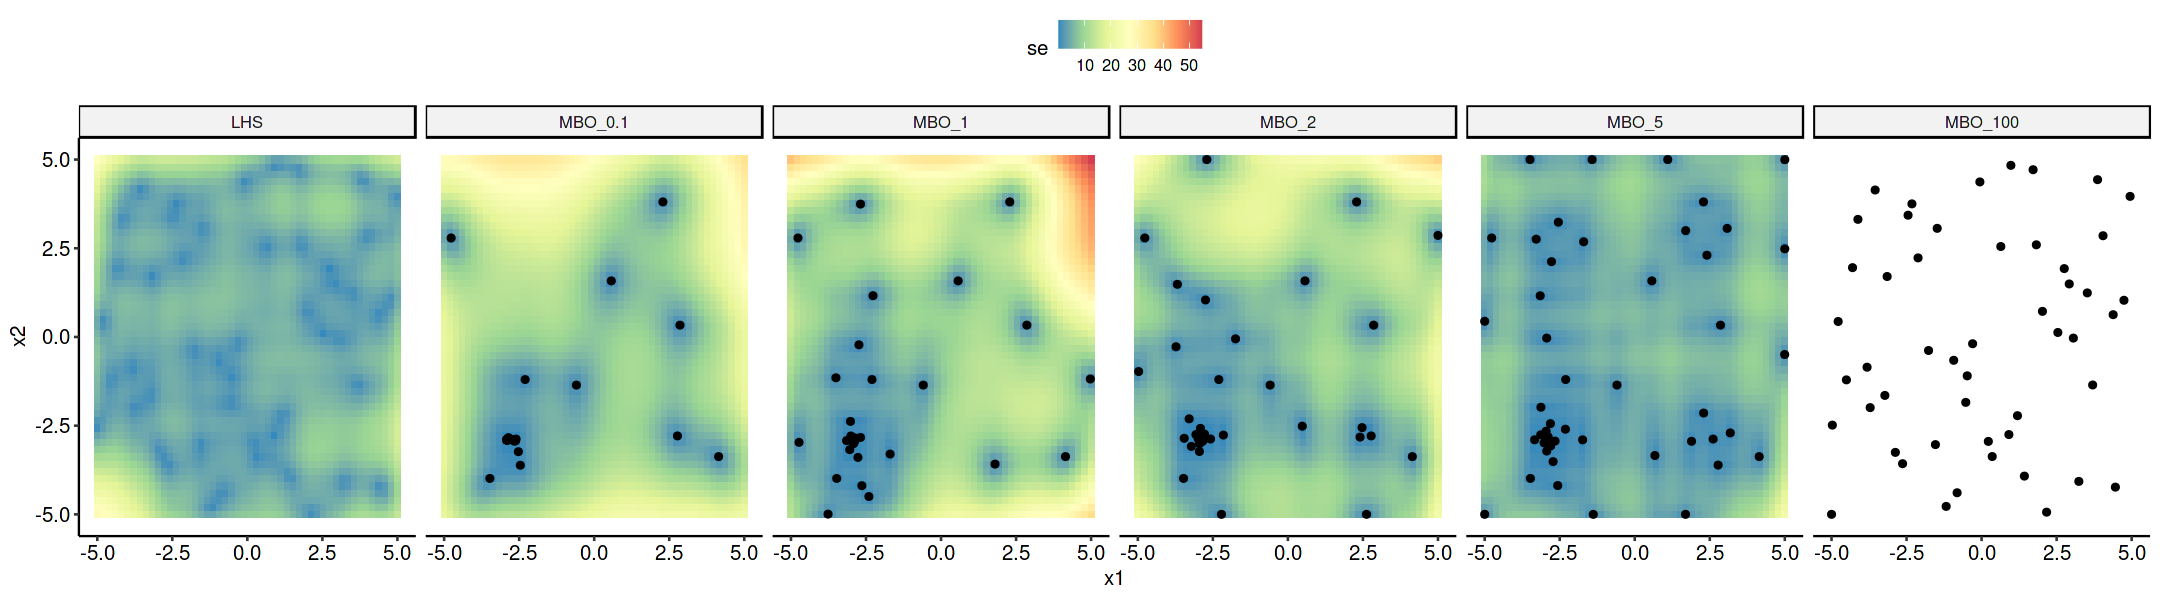

In [401]:
options(repr.plot.width=18, repr.plot.height=5)

p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

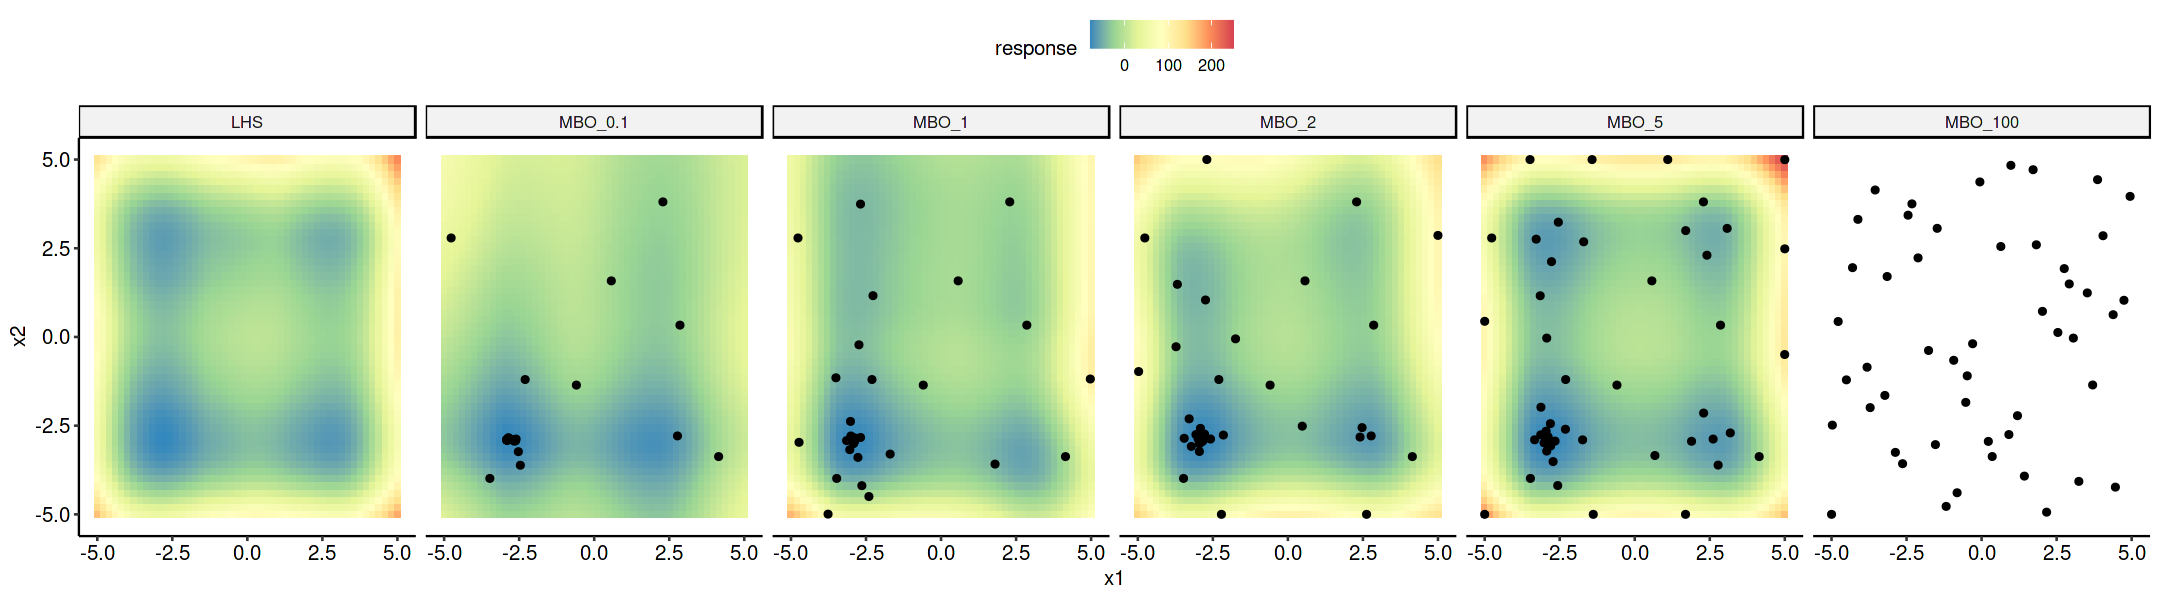

In [402]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = response))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

# High error means over-estimation 

## Maximum Mean Discrepancy

In [412]:
mmd2_estimates = lapply(runs, function(run) {
    df1 = as.data.frame(run$opt.path)[, run$models[[1]]$features]
    df2 = as.data.frame(generateRandomDesign(n = nrow(df1), ps))
    sqrt(mmd2(df1, df2))
})
mmd2_estimates

$MBO_0.1
[1] 0.5979421

$MBO_1
[1] 0.4853843

$MBO_2
[1] 0.3791989

$MBO_5
[1] 0.1994875

$LHS
[1] 0.08507161

### Question 1: Computing the PDP on Training or Test Data? 

A partial dependence plot tries to approximate the following: 

\begin{align*}
\hat f(x_S) & = \mathbb{E}_{x_C}[\hat f(x_S, x_C)] = \int \hat f(x_S, x_C) d\mathbb{P}(x_C)
\end{align*}

The mathematical correct variants of the ground-truth for $\hat f = f$ look like this: 

* Data situation 1: Ground-truth objective and $\mathbb{P}$ is the uniform distribution (ideal world)

\begin{align*}
\hat f_1(x_1) & = (-25 + 15 x_1 - 48 x_1^2 + 3 x_1^4) / 6 \\
\hat f_2(x_1) & = 8 x_1^2 - 80 cos(2 \pi x_1) + 632/3
\end{align*}

* Data situation 2: Ground-truth objective and $\mathbb{P}$ is the distribution from a perfect optimizer which immediately detects the optimum at $x^* = (-2.903.., - 2.903)$.

\begin{align*}
\hat f(x_1) & = 0.5 (x_1^4 - 16 x_1^2 + 5 x_1 - 78.3323) \\
\hat f_2(x_1) &= 20 + x_1^2 - 10 \cos(2 \pi x_1) - 10
\end{align*}

If we fit a PDP on the MBO data we usually approximate something in between. 

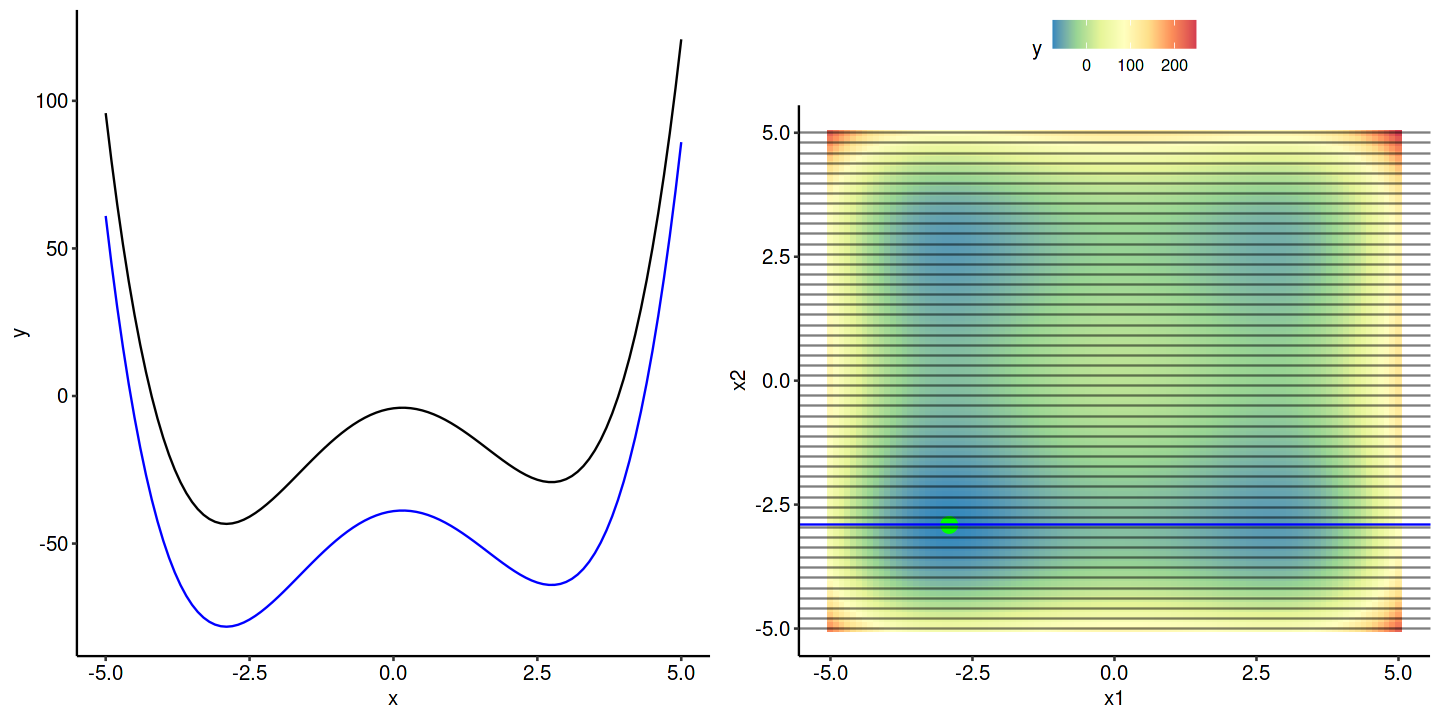

In [328]:
p1 = ggplot() + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 6 * (3 * x^4 - 48 * x^2 + 15 * x - 25))
lines = seq(-5, 5, length.out = 50)
p1 = p1 + stat_function(data = data.frame(x = c(-5, 5)), aes(x = x), fun = function(x) 1 / 2 * (x^4 - 16 * x^2 + 5 * x - 78), colour = "blue")
p2 = p_obj_1 + geom_hline(data = data.frame(yintercept = lines), aes(yintercept = yintercept), alpha = 0.5)
p2 = p2 + geom_hline(aes(yintercept = -2.903), colour = "blue")

options(repr.plot.width=12, repr.plot.height=6)

grid.arrange(p1, p2, ncol = 2)

In case 1 we are interested in the average feature effect of $x_1$ on $y$.

In case 2 we are interested in the feature effect of $x_1$ on $y$ given $x_2 = x_2^*$.

Usually, what we approximate is something in between but we converge to scenario 2. 

### Question 2: What is the Sampling Bias? 

We compare the partial dependence plots against the ground-truth PDP. 

In [23]:
data = generateRandomDesign(1000, getParamSet(obj))

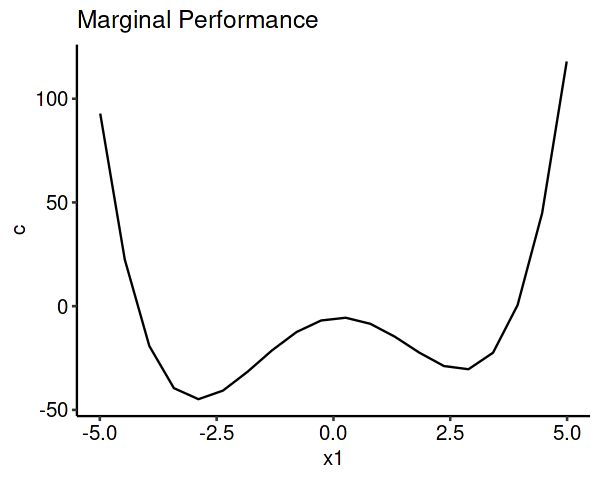

In [24]:
options(repr.plot.width=5, repr.plot.height=4)

marginal_gt = marginal_effect(obj = obj, feature = "x1", data = data, model = models[[1]], grid.size = 20, all.features = models[[1]]$features)

(p = ggplot(data = setDT(marginal_gt)[.type == "pdp", ], aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c")))

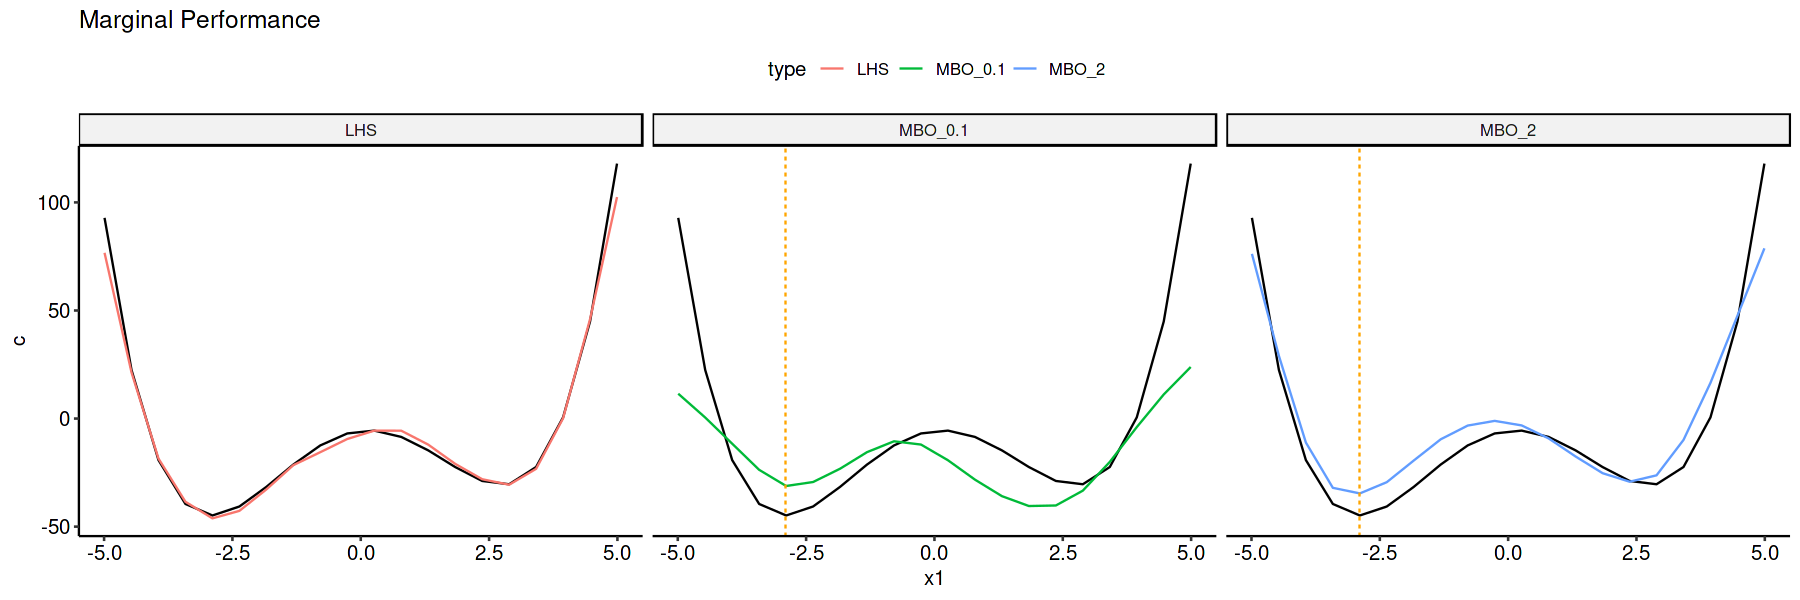

In [25]:
options(repr.plot.width=15, repr.plot.height=5)

feature = "x1"

marginal_pd = lapply(names(models), function(m) {
    pp = marginal_effect_sd_over_mean(models[[m]], feature, data, grid.size = 20, method = "pdp_var")
    # pp = predicted_marginal_effect(models[[m]], "x1", as.data.frame(runs[[m]]$opt.path))
    pp$type = m
    pp
})

mins = opdf[, .SD[which.min(y)], by = type]

marginal_pd = do.call(rbind, marginal_pd)
marginal_pd$type = factor(marginal_pd$type)#, levels = c("MBO_5","MBO_2", "MBO_1", "MBO_0.1"), labels = c("MBO_5","MBO_2", "MBO_1", "MBO_0.1")) 
marginal_pd = as.data.table(marginal_pd)

pl = p + geom_line(data = marginal_pd[type %in% c("LHS", "MBO_0.1", "MBO_2"), ], aes_string(x = feature, y = "mean", colour = "type"))                        
pl = pl + geom_vline(data = mins[type %in% c("LHS", "MBO_0.1", "MBO_2"), ], aes_string(xintercept = "x1"), colour = "orange", lty = 2)
pl + facet_grid(. ~ type)  

In [26]:
marginal_pd_sub = marginal_pd[type %in% c("MBO_0.1", "MBO_2", "LHS")]
marginal_pd_sub[type == "MBO_0.1"]$type = "High Sampling Bias"
marginal_pd_sub[type == "MBO_2"]$type = "Medium Sampling Bias"
marginal_pd_sub[type == "LHS"]$type = "Low Sampling Bias"


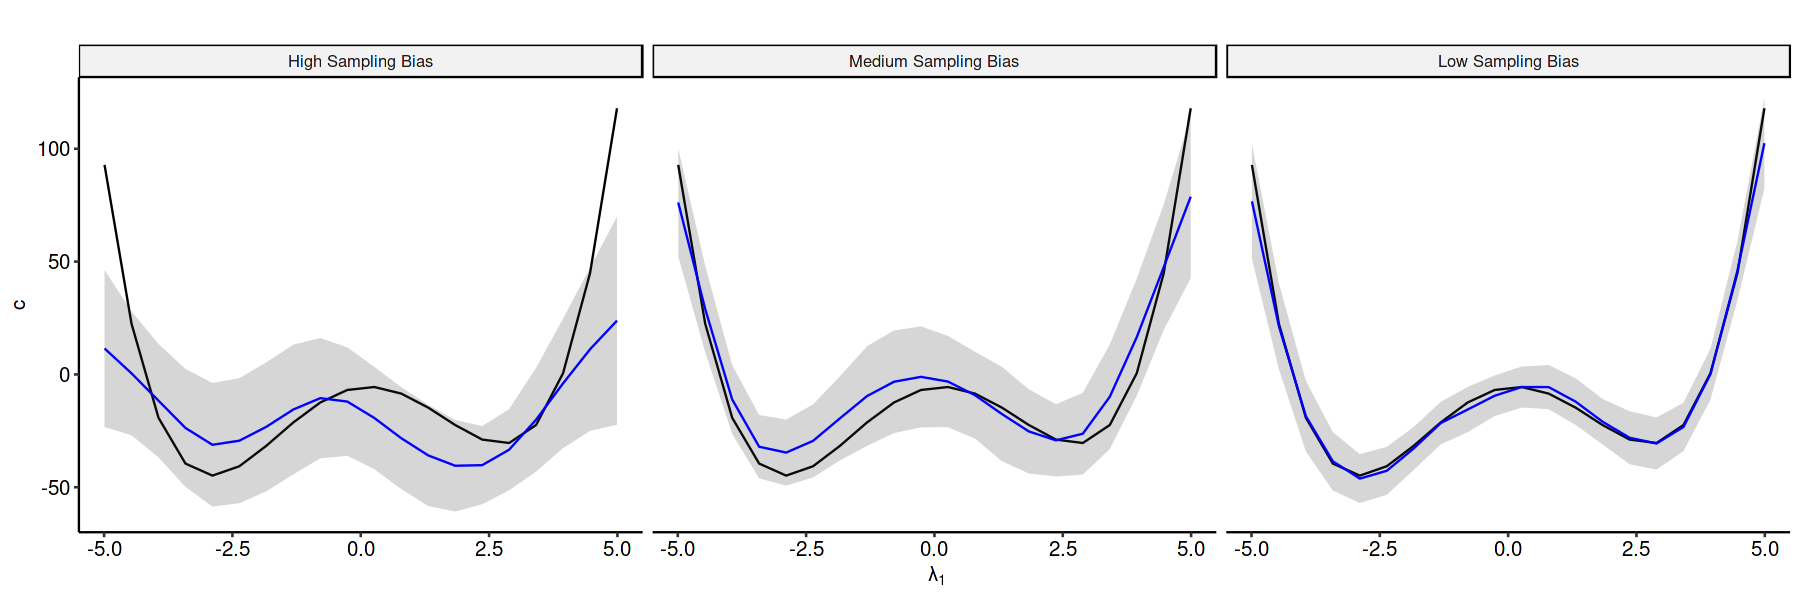

In [27]:
p = p + xlab(expression(lambda))
p1 = p + geom_ribbon(data = marginal_pd_sub, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2) 
p1 = p1 + geom_line(data = marginal_pd_sub, aes(x = x1, y = mean), colour = "blue")
p1 = p1 + xlab(~ paste("\u03BB"[1])) + facet_wrap(. ~ type ) + ggtitle("")
p1

In [28]:
ggsave("pdp_comparison.png", p1, width = 6, height = 3)

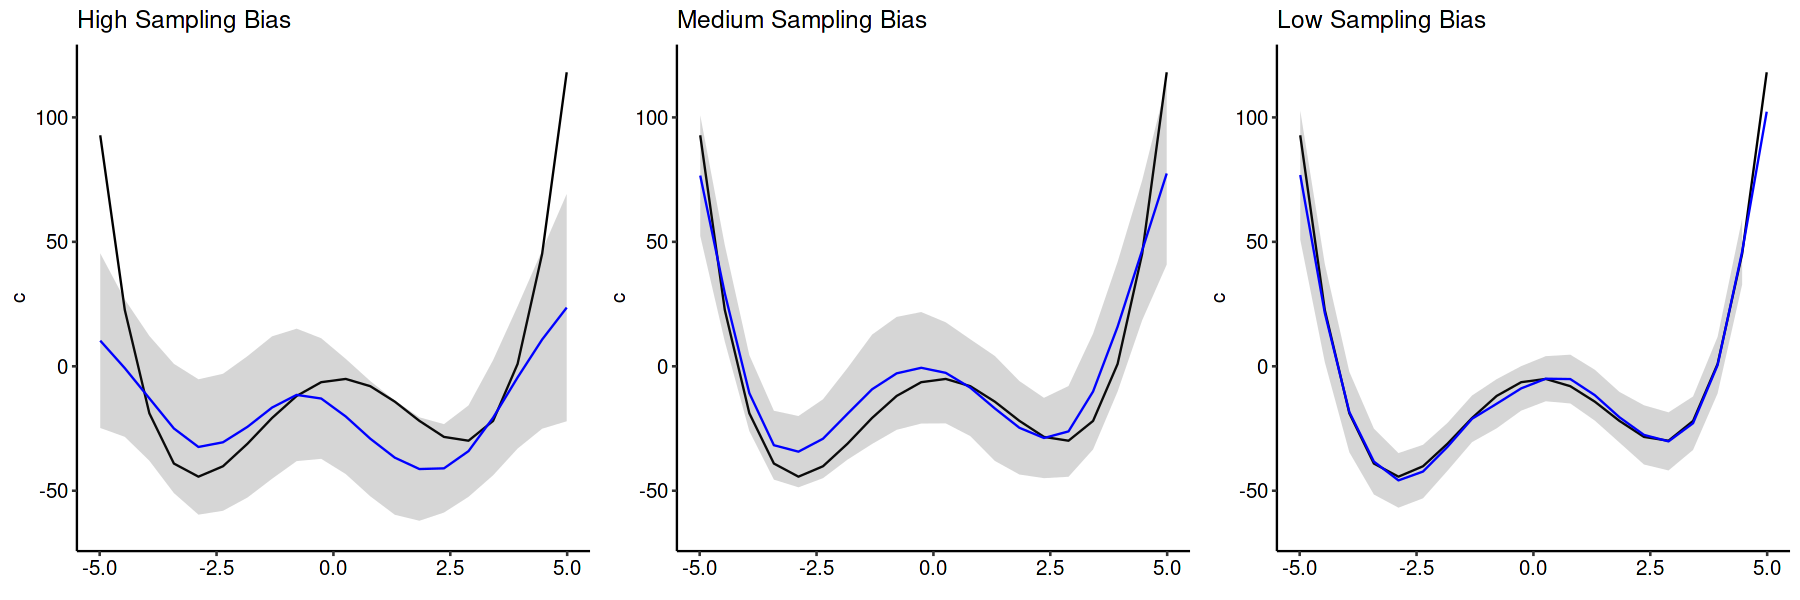

In [451]:
grid.arrange(p1, p2,p3,  nrow = 1)

In [149]:
# Capturing the bias in numbers 

# Compute the absolute deviation

res = lapply(names(models), function(m) {
    mm = marginal_pd[type == m, ]
    mm = merge(mm, marginal_gt, by = "x1")
    mm$dev_abs = mm$mean.x - mm$mean.y
    c(mean(abs(mm$dev_abs)), sd(mm$dev_abs)) 
})

res = do.call(rbind, res)
rownames(res) = names(models)
colnames(res) = c("Mean Abs. Difference", "SD Abs. Difference")
res

,Mean Abs. Difference,SD Abs. Difference
MBO_0.1,30.41479,40.42108
MBO_1,23.38789,32.72849
MBO_2,26.25527,32.97278
MBO_5,NaN,NA
MBO_10,23.72291,31.35400
MBO_100,NaN,NA


### Question 3: How Can We Capture this Effect? 

We use the uncertainty to capture this effect. 

#### Variant 1 (Partial Dependence Plot over the Posterior Variance)

$$
    \hat s(\lambda_S) = \sqrt{\frac{1}{n^2} \sum_{i = 1}^n \hat s^2(\lambda^{(i)})} = \frac{1}{n} \sqrt{ \sum_{i = 1}^n \hat s^2(\lambda^{(i)})}
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 2 (Partial Dependence Plot over Standard Deviation)

At least in my opinion, this is not mathematically valid...?

$$
    \hat s(\lambda_S) = \frac{1}{n}  \sum_{i = 1}^n \hat s(\lambda^{(i)})
$$

with $\lambda^{(i)} \sim \textrm{Unif}(X(\lambda_S))$

#### Variant 3 (Partial Dependence Taking into Account GP Covariance)

$$
    \hat s(\lambda_S) = \frac{1}{n} \sqrt{\sum_{i,j} K^{(post)}_{i,j}}
$$

In [120]:
models

$MBO_0.1
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$MBO_1
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$MBO_2
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08

$MBO_10
Model for learner.id=regr.km; learner.class=regr.km
Trained on: task.id = data; obs = 70; features = 3
Hyperparameters: jitter=FALSE,covtype=matern3_2,optim.method=gen,nugget.stability=1e-08


In [127]:
results = list()

for (method in c("pdp_var_gp")) {
    res = lapply(names(models), function(m) {
        pp = marginal_effect_sd_over_mean(model = models[[m]], feature = "x1", data = data, method = method, grid.size = 20)
        # pp = marginal_effect_sd_over_mean(models[[m]], "x1", as.data.frame(runs[[m]]$opt.path), method = method)
        pp$type = m
        pp
    })
    res = do.call(rbind, res)
    res$method = method
    results[[method]] = res
}

In [128]:
results = do.call(rbind, results)

In [138]:
alpha = 0.01

In [139]:
results$upper = unlist(lapply(seq_row(results), function(i) {
    qnorm(p = 1 - alpha / 2, mean = results[i, ]$mean, sd = results[i, ]$sd)
}))

results$lower = unlist(lapply(seq_row(results), function(i) {
    qnorm(p = alpha / 2, mean = results[i, ]$mean, sd = results[i, ]$sd)
}))

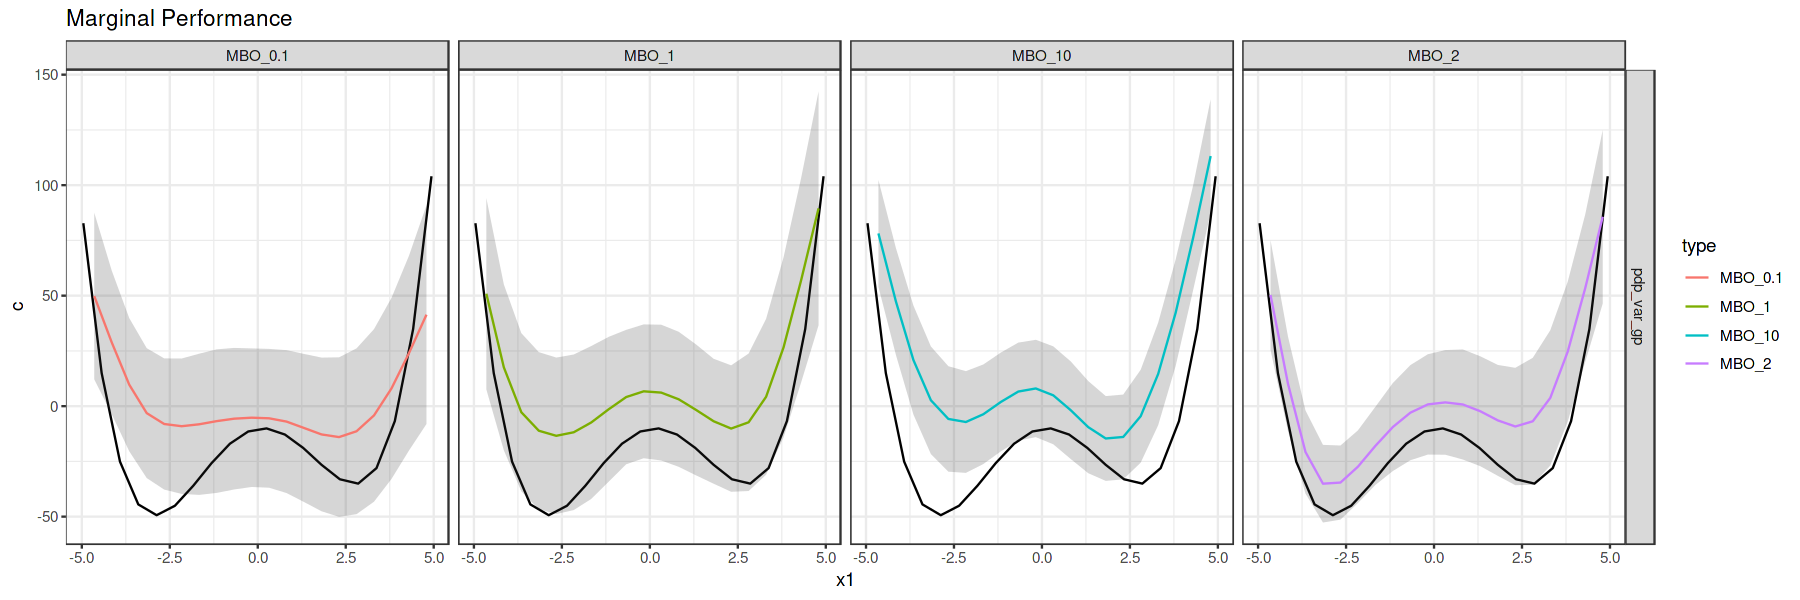

In [140]:
options(repr.plot.width=15, repr.plot.height=5)

q = qnorm(1 - alpha / 2)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, ymin = mean - q * sd, ymax = mean + q * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(method ~ type)
pl

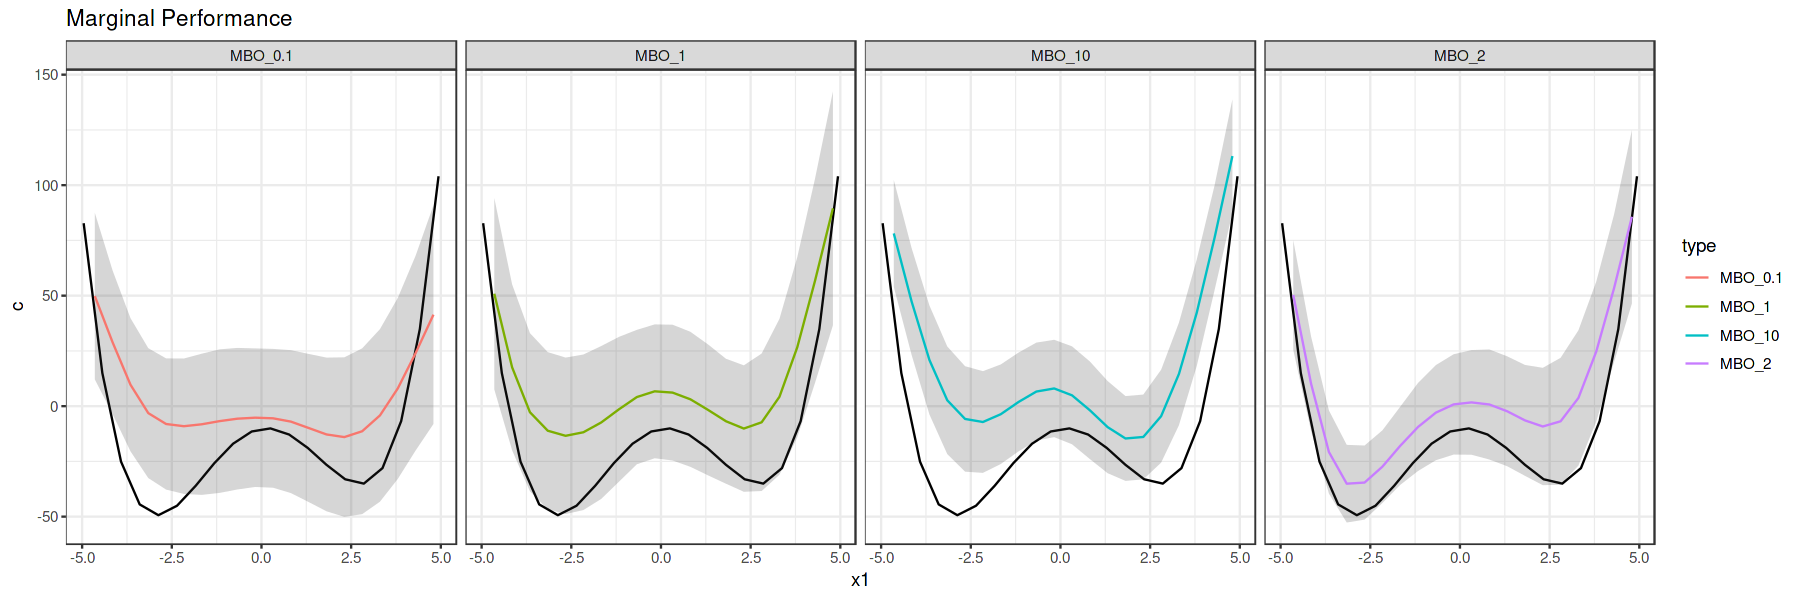

In [141]:
options(repr.plot.width=15, repr.plot.height=5)

pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, ymin = lower, ymax = upper), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var_gp"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(. ~ type)
pl

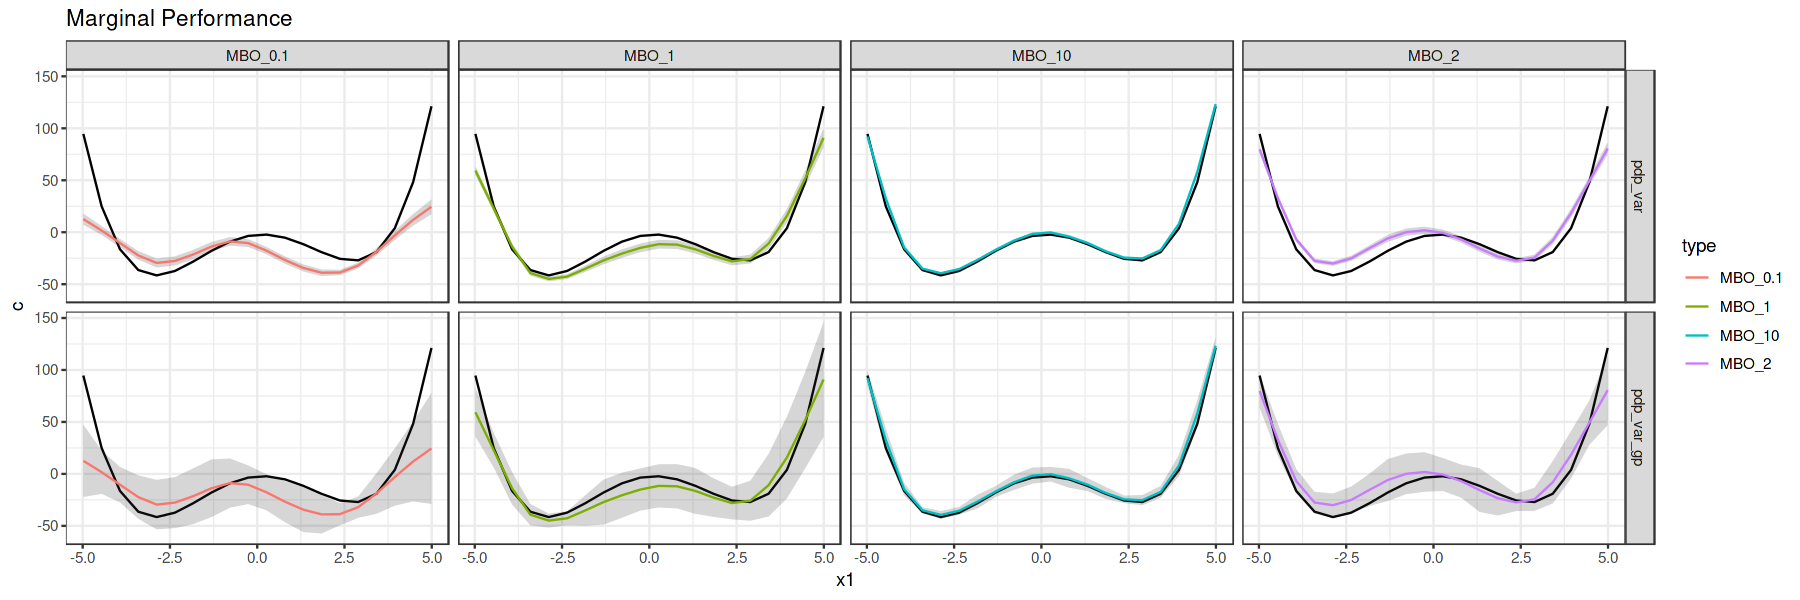

In [27]:
# with Bonferroni correction

alpha = 0.05
m = 20

alpha_corr = alpha / m

q = qnorm(1 - alpha_corr / 2)
pl = p + geom_ribbon(data = results[method %in% c("pdp_var"), ], aes(x = x1, ymin = mean - q * sd, ymax = mean + q * sd), alpha = 0.2)
pl = pl + geom_line(data = results[method %in% c("pdp_var"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(method ~ type)
pl2 = pl
pl

In [43]:
# options(repr.plot.width=9, repr.plot.height=9)

# pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "thompson"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
# pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "thompson"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
# pl

In [44]:
# options(repr.plot.width=9, repr.plot.height=9)

# pl = p + geom_ribbon(data = results[method %in% c("pdp_var_gp", "pdp_var"), ], aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
# pl = pl + geom_line(data = results[method %in% c("pdp_var_gp", "pdp_var"), ], aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
# pl

In [45]:
# Alternative Approach 
# results2 = list()

# for (method in c("pdp_cond", "pdp_cond_thomps")) {
#     res = lapply(names(models), function(m) {
#         pp = conditional_mean_sd(models[[m]], "x1", data, method = method)
#         pp$type = m
#         pp
#     })
#     res = do.call(rbind, res)gginnards
#     res$method = method
#     results2[[method]] = res
# }

In [40]:
# results2 = do.call(rbind, results2)

In [46]:
# options(repr.plot.width=8, repr.plot.height=12)

# pl = p + geom_ribbon(data = results2, aes(x = x1, ymin = mean - 2 * sd, ymax = mean + 2 * sd), alpha = 0.2)
# pl = pl + geom_line(data = results2, aes(x = x1, y = mean, colour = type)) + facet_grid(type ~ method)
# pl

In [ ]:
model = models[[1]]

predictor = Predictor$new(model, data = data)

effects = FeatureEffect$new(predictor = predictor, feature = feature, grid.size = 2, method = "ice")

# Extract the learned GP 
km = model$learner.model

# Covtype is needed later to extract the covariance 
covtype = attr(km, "covariance")

# Compute the covariance matrix and the mean for this whole design 
design = merge(effects$results$x1, predictor$data$X$x2)
names(design) = c("x1", "x2")

# Predict on this big design 
pred = predict(object = km, newdata = design, type = "SK", cov.compute = TRUE)
C = pred$cov
m = pred$mean 

dfl = cbind(id = seq_row(design), design, m = m, C = C)

In [81]:
feature = "x1"
gridvalues = me[, feature]

In [82]:
km = models[[1]]$learner.model

In [83]:
res = lapply(gridvalues, function(gv) {

    # Create vector along the gridvalue gv by combining it with the "test dataset"
    gg = merge(gv, data[, setdiff(colnames(data), feature)])
    names(gg) = c(feature, setdiff(colnames(data), feature))
    gg = gg[, names(data)]

    # Compute the posterior mean and covariance of the predictions at points in gg

    return(gg)
})

In [84]:
res = do.call(rbind, res)

In [85]:
pred = predict(object = km, newdata = res, type = "SK", cov.compute = TRUE)
C = pred$cov
m = pred$mean 

## Further Visualization for the Paper

In [612]:
# Plot a PDP with two ICE curves 

lambda = 0.1

model = models[["MBO_0.1"]]
df = opdf[type == "MBO_0.1"]
df$c = df

In [624]:
gg$c = gg$y
p_obj_1 = ggplot() + geom_tile(data = gg, aes(x = x1, y = x2, fill = c))
p_obj_1 = p_obj_1 + scale_fill_distiller(palette = "Spectral")
# p_obj_1 = p_obj_1 + geom_point(data = data.frame(x = -2.91, y = -2.91), aes(x = x, y = y), colour = "green", size = 4)


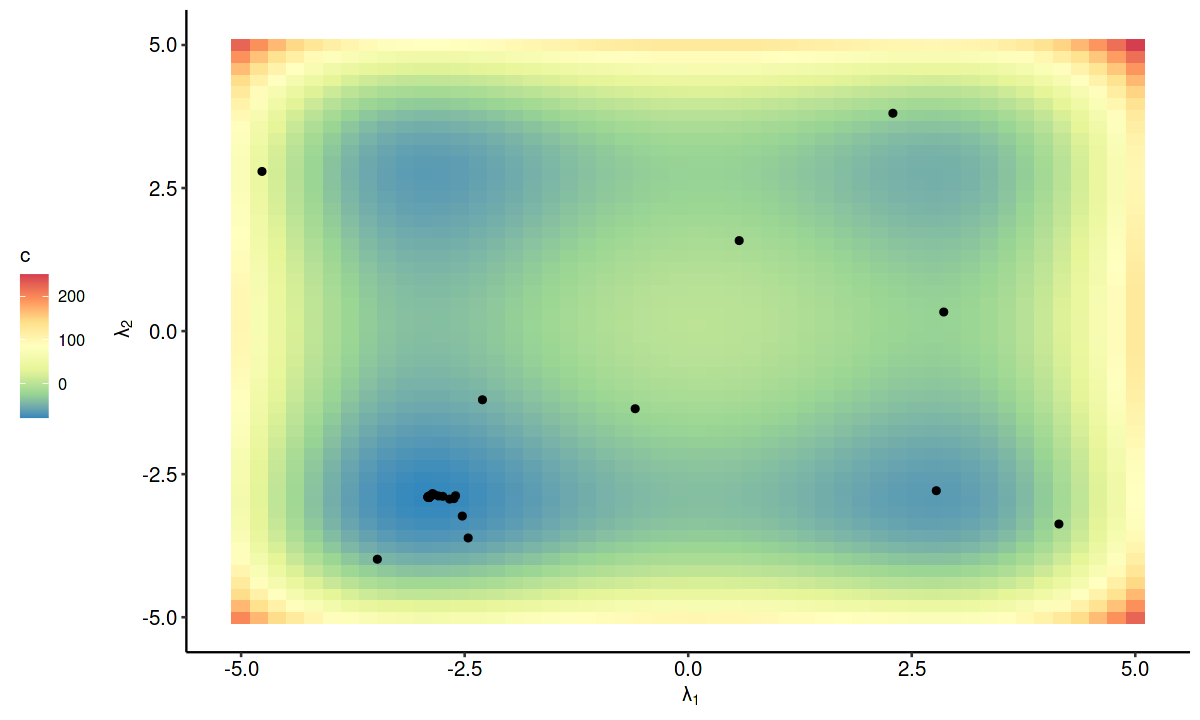

In [627]:
p = p_obj_1 + geom_point(data = df, aes(x = x1, y = x2)) + xlab(~ paste("\u03BB"[1])) + ylab(~ paste("\u03BB"[2]))
p = p + theme(legend.position = "left")
p

In [628]:
# ICE Curve 1 

gridvalues = seq(-5, 5, length.out = 20)

id1 = 2
id2 = 17

ic1 = data.frame(x1 = gridvalues, x2 = df[id1, ]$x2)
ic1$y = apply(ic1, 1, obj)

ic2 = data.frame(x1 = gridvalues, x2 = df[id2, ]$x2)
ic2$y = apply(ic2, 1, obj)
ic2$type = "2"
ic1$type = "1"


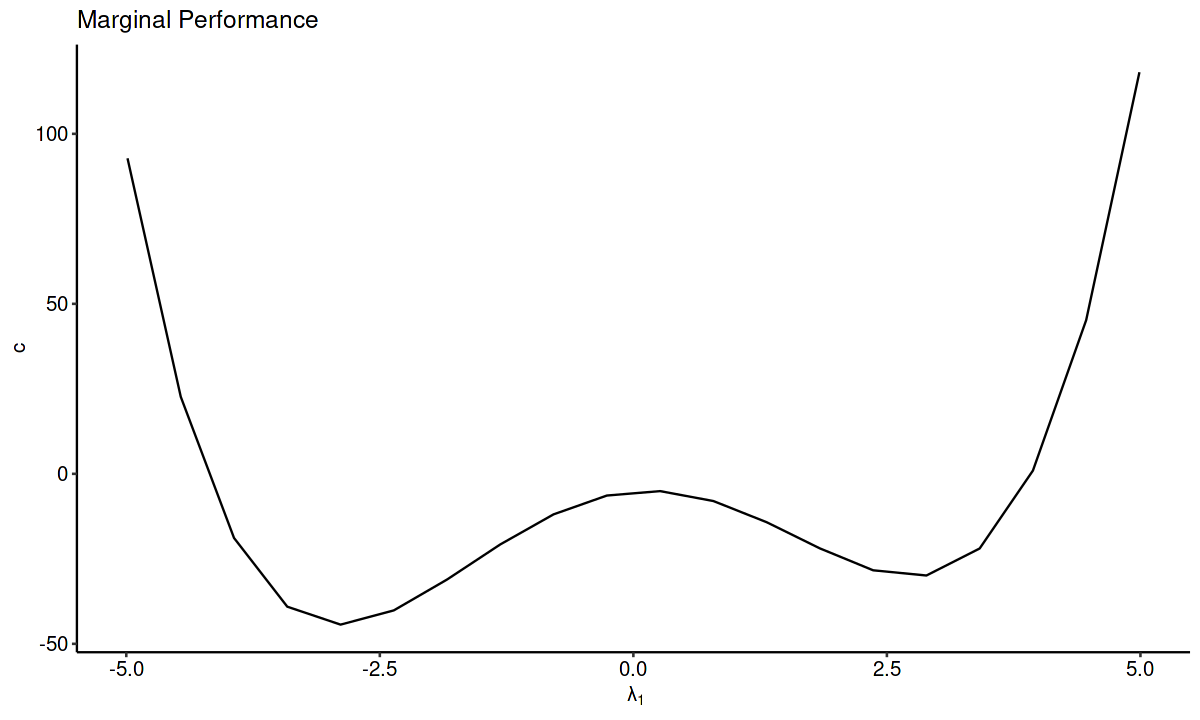

In [629]:
pgt = ggplot(data = setDT(marginal_gt)[.type == "pdp", ], aes(x = x1, y = mean)) + geom_line() + ggtitle("Marginal Performance") + ylab(c("c"))
pgt = pgt + xlab(~ paste("\u03BB"[1])) 
pgt

In [630]:
ic = rbind(ic1, ic2)

In [631]:
ic = cbind(ic, predict(model, newdata = ic[, c("x1", "x2")])$data)

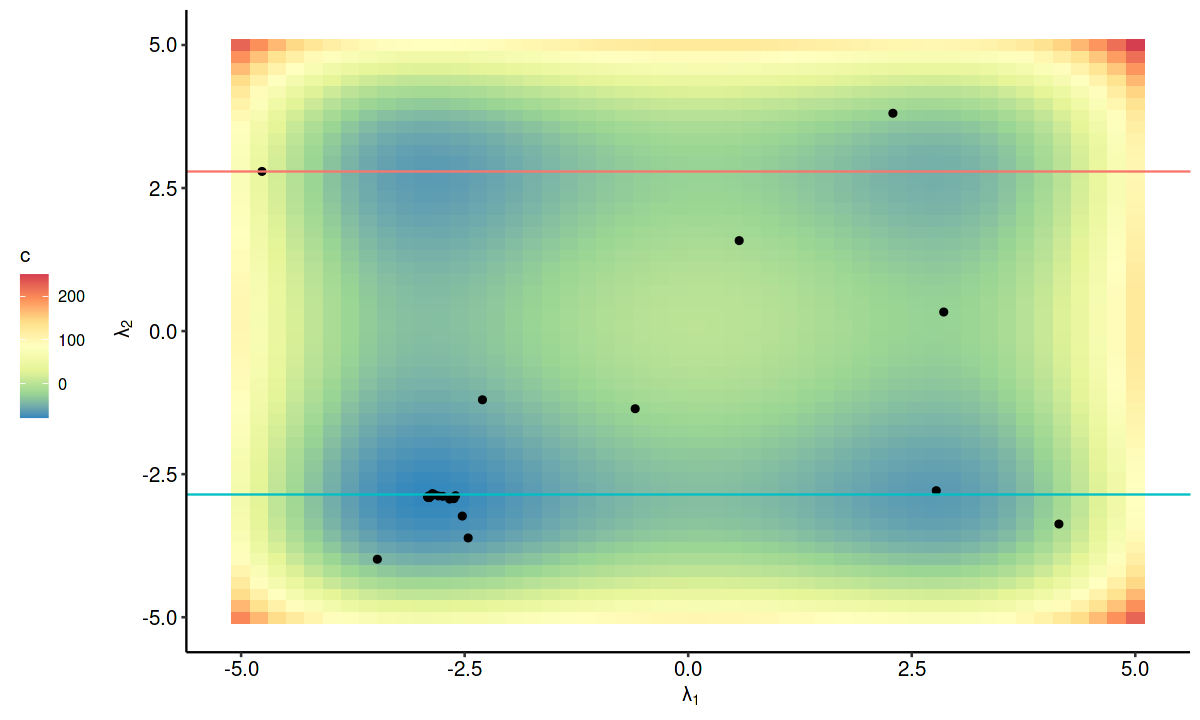

In [637]:
p1 = p + geom_hline(data = ic, aes(yintercept = x2, colour = type), show.legend = FALSE)
p1

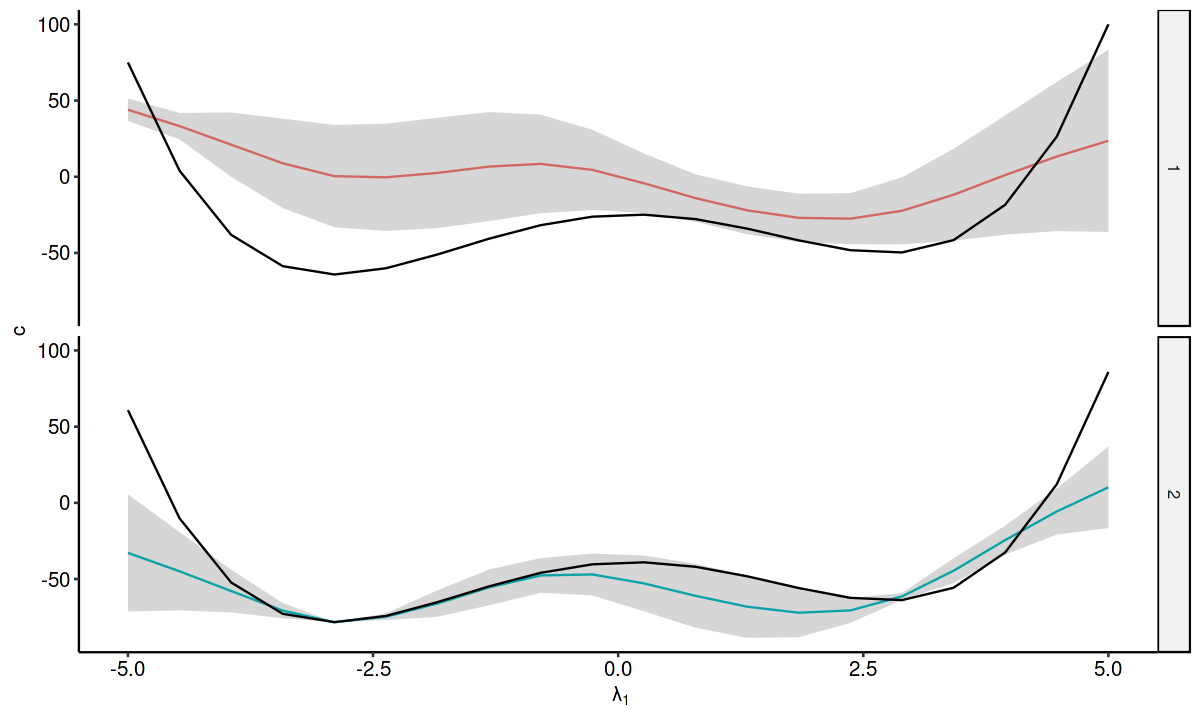

In [638]:
p2 = ggplot() + geom_line(data = ic, aes(x = x1, y = response, colour = type))
p2 = p2 + geom_ribbon(data = ic, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), alpha = 0.2)
p2 = p2 + geom_line(data = ic, aes(x = x1, y = y)) + xlab(~ paste("\u03BB"[1]))  + ylab("c")
p2 = p2 + facet_grid(type ~ .) + theme(legend.position = "none")
p2

In [646]:
ggsave("ice_curves_example.png", ggarrange(p1, p2, nrow = 1, common.legend = TRUE), width = 7, height = 3.5)

In [150]:
plotPDPICE = function(obj, runtype, feature, testdata_runtype, gt = FALSE) {
    opdf_sub = data.frame(opdf[cb.lambda.t == testdata_runtype, ])
    predictor = Predictor$new(models[[runtype]], data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp+ice")
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(feature)
        p = p + geom_line(data = df, aes(x = x, y = y), colour = "blue", lty = 2)
    }    
    return(p)
}

In [151]:
options(repr.plot.width=12, repr.plot.height=6)

p1 = plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("MBO-model on test data") 
p2 = plotPDP(obj1, "LHS", "x1", "LHS", gt = TRUE, se = TRUE) + ggtitle("LHS-model on test data") 
grid.arrange(p1, p2, ncol = 2)

ERROR: Error in plotPDP(obj1, "lambda1", "x1", "LHS", gt = TRUE, se = TRUE): could not find function "plotPDP"


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 6)

preds = setDT(preds)

example_ice_curves = data.frame(y = c(2.5, -1), type = c("ice_curve_1", "ice_curve_2"))

# Explanation
p2 = ggplot() + geom_tile(data = preds[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf[cb.lambda.t == "lambda1", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 = p2 + geom_hline(data = example_ice_curves, aes(yintercept = y, colour = type))

In [ ]:
options(repr.plot.width = 14, repr.plot.height = 6)

x1 = seq(-5, 5, by = 0.01)
df_ice = data.frame(x1 = x1, x2 = example_ice_curves$y[1], type = "ice_curve_1")
df_ice = rbind(df_ice, data.frame(x1 = x1, x2 = example_ice_curves$y[2], type = "ice_curve_2"))
pred = predict(models[["lambda1"]], newdata = df_ice[, c("x1", "x2")])
df_ice$response = pred$data$response
df_ice$se = pred$data$se
df_ice$gt = apply(df_ice[, c("x1", "x2")], 1, obj1)

p1 = ggplot() 
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)

In [ ]:
p1 = ggplot()
p1 = p1 + geom_ribbon(data = df_ice, aes(x = x1, ymin = response - 2 * se, ymax = response + 2 * se), fill = "grey70", alpha = 0.5)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = gt, group = type), colour = "blue", lty = 2)
p1 = p1 + geom_line(data = df_ice, aes(x = x1, y = response, colour = type))
p1 = p1 + facet_grid(type ~ .)

grid.arrange(p2, p1, ncol = 2)